# Gene Set Enrichment Using GSEAPY

In [ ]:
!pip install gseapy
!pip install pandas
!pip install scanpy
!pip install matplotlib
!pip install numpy

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy
import matplotlib.pyplot as plt
import warnings
import os
import urllib.request

warnings.simplefilter(action="ignore", category=Warning)

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 2

sc.settings.set_figure_params(dpi=80)

## Read Data

In [4]:
# download pre-computed data if missing or long compute
fetch_data = True

# url for source and intermediate data
path_data = "https://export.uppmax.uu.se/naiss2023-23-3/workshops/workshop-scrnaseq"

path_results = "data/covid/results"
if not os.path.exists(path_results):
    os.makedirs(path_results, exist_ok=True)

# path_file = "data/covid/results/scanpy_covid_qc_dr_scanorama_cl.h5ad"
path_file = "data/covid/results/scanpy_covid_qc_dr_scanorama_cl.h5ad"
if fetch_data and not os.path.exists(path_file):
    urllib.request.urlretrieve(os.path.join(
        path_data, 'covid/results/scanpy_covid_qc_dr_scanorama_cl.h5ad'), path_file)

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 7222 × 2626
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_1.0', 'leiden_0.6', 'leiden_0.4', 'leiden_1.4', 'louvain_1.0', 'louvain_0.6', 'louvain_0.4', 'louvain_1.4', 'kmeans5', 'kmeans10', 'kmeans15', 'hclust_5', 'hclust_10', 'hclust_15'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dendrogram_leiden_0.6', 'dendrogram_louvain_0.6', 'doublet_info_colors', 'hclust_10_colors', 'hclust_15_colors', 'hclust_5_colors', 'hvg', 'kmeans10_colors', 'kmeans15_colors', 

In [5]:
#Use Data in raw (normalized and log transformed)
adata = adata.raw.to_adata()
print(adata.X[:10,:10])

  (1, 4)	0.7825693876867097
  (8, 7)	1.1311041336746985


## Hypergeometric enrichment test
Having a defined list of differentially expressed genes, you can now look for their combined function using hypergeometric test

In [6]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Per

#### Get significant DEGs

In [10]:
#Find Differentially expressed genes per group
sc.tl.rank_genes_groups(adata,'type',method='wilcoxon',key_added='wilcoxon')
#add differential genes above cutoffs to a list
glist = sc.get.rank_genes_groups_df(adata, group='Covid', key='wilcoxon', log2fc_min=0.25, pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
print(len(glist))

ranking genes
    finished (0:00:05)
1318


#### Perform Enrichment Test

In [11]:
#Perform statistical overenrichment testing on gene list
enr_res = gseapy.enrichr(gene_list=glist, organism='Human', 
                         gene_sets='GO_Biological_Process_2018', cutoff = 0.5)
enr_res.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,neutrophil activation involved in immune respo...,149/483,7.277551e-61,2.789485e-57,0,0,7.001870,969.569171,FCN1;CDA;CYFIP1;MPO;PYCARD;LGALS3;PNP;ANPEP;FT...
1,GO_Biological_Process_2018,neutrophil degranulation (GO:0043312),148/479,1.495629e-60,2.866372e-57,0,0,7.013061,966.067052,FCN1;CDA;CYFIP1;MPO;PYCARD;LGALS3;PNP;ANPEP;FT...
2,GO_Biological_Process_2018,neutrophil mediated immunity (GO:0002446),149/487,2.468563e-60,3.154000e-57,0,0,6.917499,949.436889,FCN1;CDA;CYFIP1;MPO;PYCARD;LGALS3;PNP;ANPEP;FT...
3,GO_Biological_Process_2018,cytokine-mediated signaling pathway (GO:0019221),142/633,8.304955e-40,7.958223e-37,0,0,4.473589,402.562867,IFITM3;IFITM1;IL1RN;CSF3R;IFITM2;F13A1;IRS2;IL...
4,GO_Biological_Process_2018,cellular response to cytokine stimulus (GO:007...,89/456,9.195449e-21,7.049231e-18,0,0,3.613924,166.730461,RIPOR2;CDKN1A;IL1RN;CSF3R;ITGAM;CXCL8;FLT3;F13...


<Axes: title={'center': 'GO_Biological_Process_2018'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

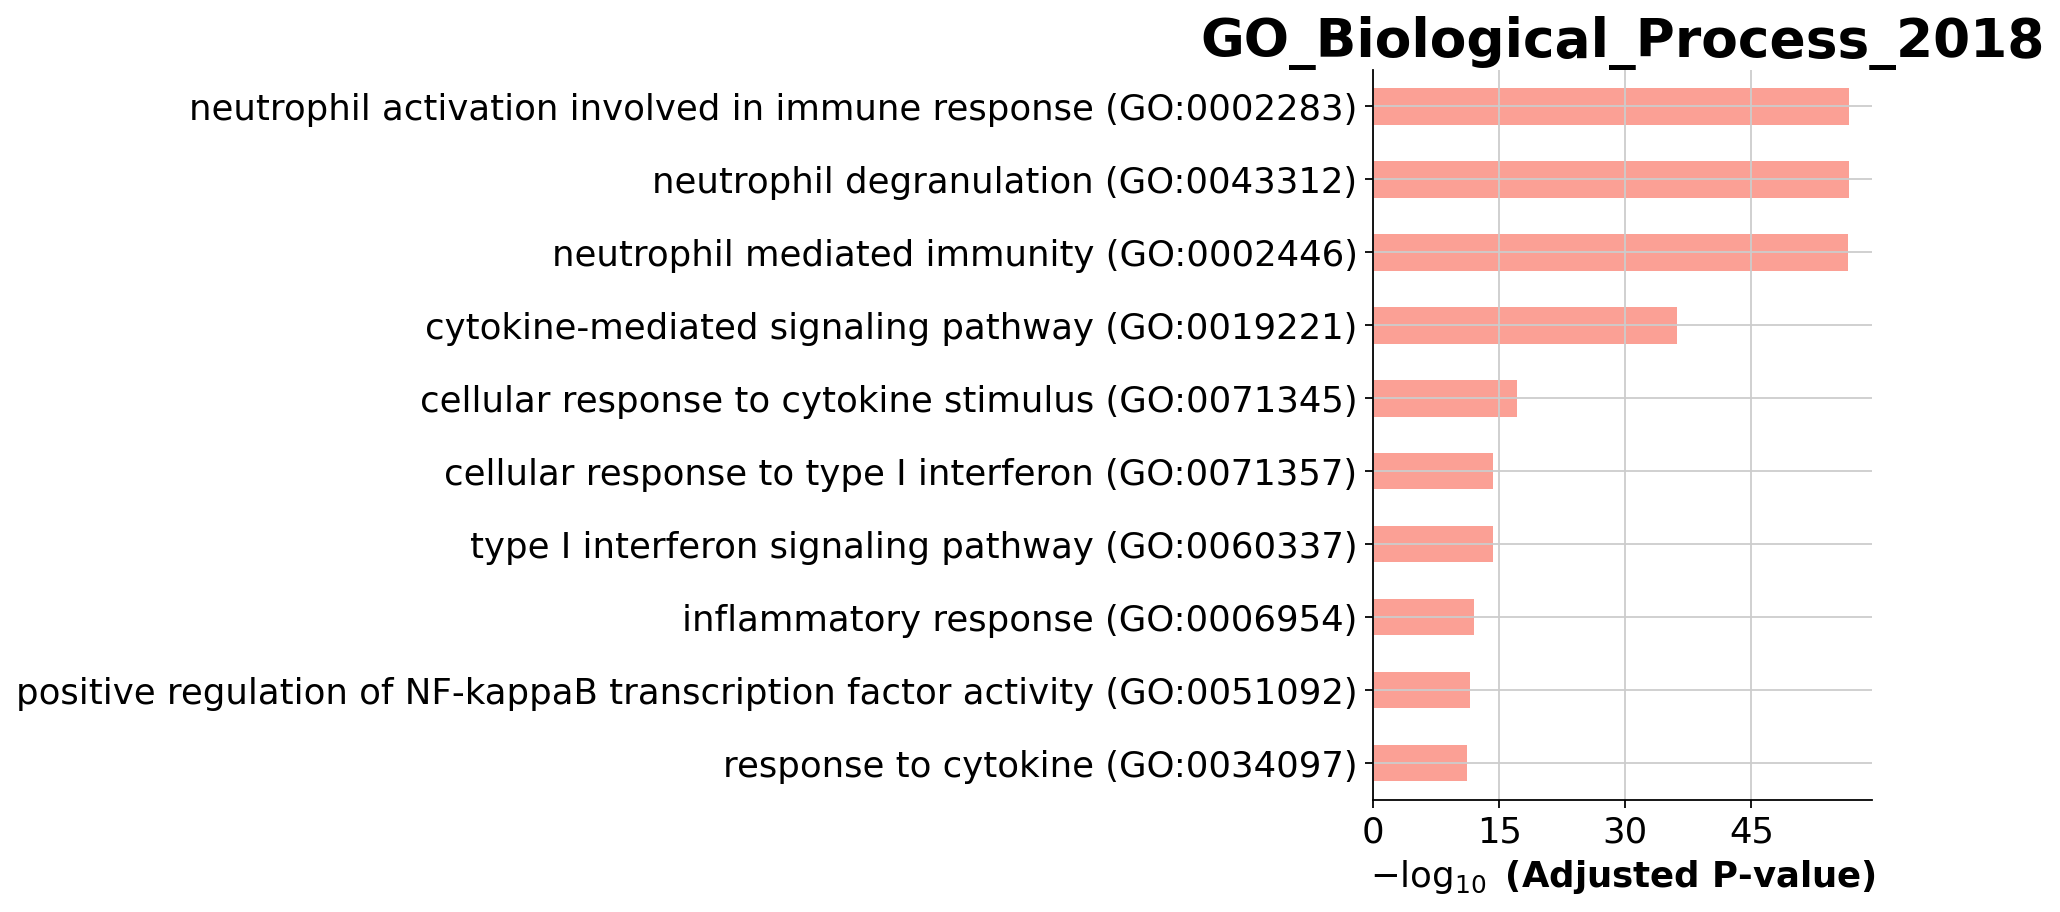

In [12]:
gseapy.barplot(enr_res.res2d,title='GO_Biological_Process_2018')

## Gene Set Enrichment Analysis
Besides the enrichment using hypergeometric test, we can also perform gene set enrichment analysis (GSEA), which scores ranked genes list (usually based on fold changes) and computes permutation test to check if a particular gene set is more present in the Up-regulated genes, among the DOWN_regulated genes or not differentially regulated.

In [14]:
#Extract differential genes and statistics (logfoldchanges)
gene_rank = sc.get.rank_genes_groups_df(adata, group='Covid', key='wilcoxon')[['names','logfoldchanges']]
gene_rank.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

# calculate_qc_metrics will calculate number of cells per gene
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# filter for genes expressed in at least 30 cells.
gene_rank = gene_rank[gene_rank['names'].isin(adata.var_names[adata.var.n_cells_by_counts>30])]

gene_rank

,names,logfoldchanges
2798,CCL7,24.207840
2872,IL1A,24.117371
2394,CYP19A1,23.743271
2910,PRTN3,23.375751
1094,NXF3,9.238131
...,...,...
15300,CD1E,-5.020958
15841,C5orf17,-5.107718
17459,LYPD2,-5.691773
15488,NOG,-23.027763


We can use the package to get gene set from the Molecular Signature Database (MSigDB) and select KEGG pathways as an example.

In [15]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Per

Next, we will run GSEA. This will result in a table containing information for several pathways. 

We can then sort and filter those pathways to visualize only the top ones. You can select/filter them by either p-value or normalized enrichment score (NES).

In [16]:
res = gseapy.prerank(rnk=gene_rank, gene_sets='KEGG_2021_Human')

terms = res.res2d.Term
terms[:10]

0                              IL-17 signaling pathway
1                                 Rheumatoid arthritis
2    Viral protein interaction with cytokine and cy...
3               Cytokine-cytokine receptor interaction
4    AGE-RAGE signaling pathway in diabetic complic...
5                          Chemokine signaling pathway
6               Fluid shear stress and atherosclerosis
7                           Osteoclast differentiation
8                                            Pertussis
9                  Complement and coagulation cascades
Name: Term, dtype: object

[<Axes: xlabel='Gene Rank', ylabel='Ranked metric'>,
 <Axes: >,
 <Axes: >,
 <Axes: ylabel='Enrichment Score'>]

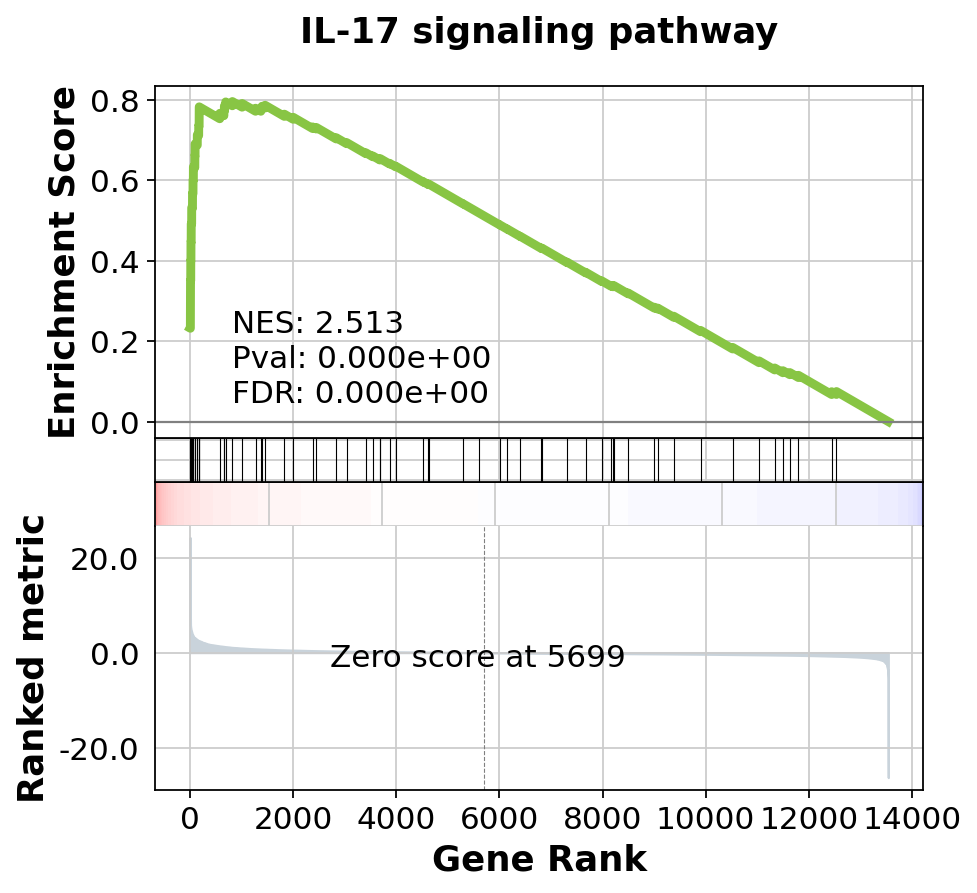

In [17]:
gseapy.gseaplot(rank_metric=res.ranking, term=terms[0], **res.results[terms[0]])